## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# --- 1. Define File Paths ---
# These are the paths specified in your project environment.y structure.
LABELS_PATH = '/datasets/faces/labels.csv'
IMAGES_PATH = '/datasets/faces/final_files/'

In [2]:
# --- 2. Load the Data with Pandas ---
print("--- Loading labels.csv ---")
try:
    labels_df = pd.read_csv(LABELS_PATH)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {LABELS_PATH}")
    # As a fallback, create a dummy dataframe so the rest of the script doesn't crash.
    labels_df = pd.DataFrame({'file_name': [], 'real_age': []})

--- Loading labels.csv ---
File loaded successfully!


## EDA


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

--- Descriptive Statistics for Age ---
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

--- Plotting Age Distribution ---


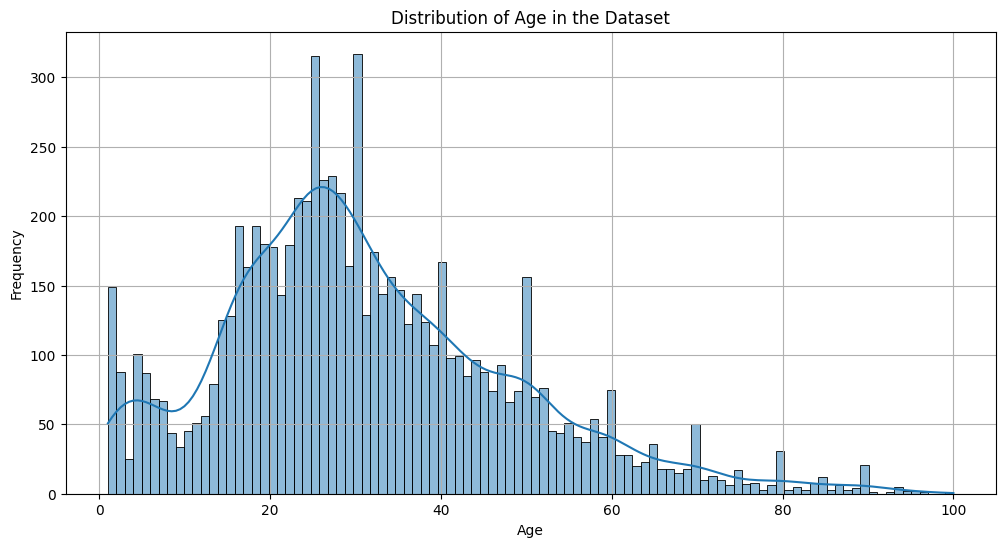


--- Displaying Sample Images ---


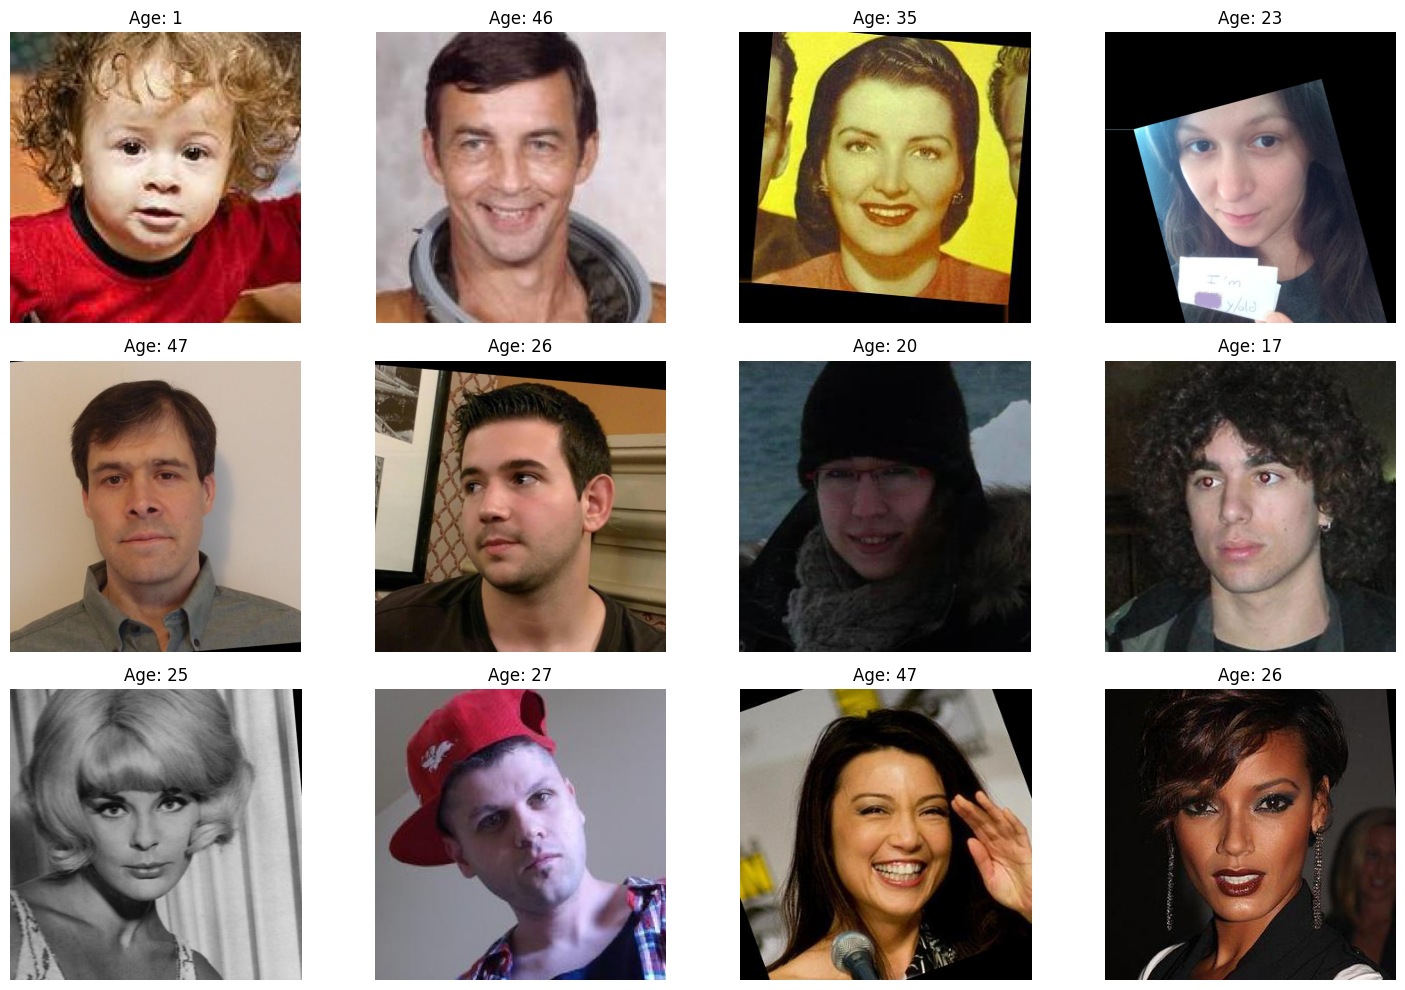

In [3]:
# --- 3. Perform Exploratory Data Analysis (EDA) ---
if not labels_df.empty:
    # --- Data Structure and Statistics ---
    print("\n--- Data Information ---")
    labels_df.info()

    print("\n--- Descriptive Statistics for Age ---")
    print(labels_df['real_age'].describe())

    # --- Visualize Age Distribution ---
    print("\n--- Plotting Age Distribution ---")
    plt.figure(figsize=(12, 6))
    sns.histplot(labels_df['real_age'], bins=100, kde=True)
    plt.title('Distribution of Age in the Dataset')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # --- Display a Sample of Images ---
    print("\n--- Displaying Sample Images ---")
    # Create a figure to display the images
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Get a random sample of 12 images from the dataframe
    sample_df = labels_df.sample(12, random_state=42)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        ax = axes[i]
        try:
            # Construct the full path to the image
            img_path = os.path.join(IMAGES_PATH, row['file_name'])
            # Open the image using PIL
            img = Image.open(img_path)
            # Display the image
            ax.imshow(img)
            # Set the title to the corresponding age
            ax.set_title(f"Age: {row['real_age']}")
        except FileNotFoundError:
            # If an image is not found, show a placeholder text
            ax.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"Age: {row['real_age']}")
        
        # Turn off the axis labels
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("\nCould not perform EDA because the DataFrame is empty.")

### Conclusiones

Based on the exploratory data analysis, here are the main conclusions about the dataset.


## Data Overview

The dataset consists of **7,591 images**, each paired with a person's age. The data is clean, with no missing values. The ages range from **1 to 100 years**, with an average age of approximately **31**. The analysis confirms that the task is a **regression problem**, as the goal is to predict a specific numerical age.


## Key Findings & Implications for Modeling

### 1. Age Distribution is Unbalanced

The most significant finding is the **uneven distribution of ages**. As seen in the histogram, there is a large concentration of images for people in their **20s and 30s**, with a smaller peak for infants. People over 60 are significantly underrepresented.

* **Implication:** This imbalance will likely cause the model to be more accurate when predicting the age of young adults. It may struggle with older age groups due to the lack of sufficient training examples.


### 2. Image Variety is High

The sample images reveal a wide variety of conditions:
* Different head poses and camera angles (some images are rotated).
* Varied lighting and image quality.
* A mix of color and black-and-white photos.
* Obstructions and non-centered faces.

* **Implication:** This diversity makes the task more challenging. However, it also means that a model successfully trained on this data will be more **robust** and better equipped to handle real-world images, which are rarely perfect. Techniques like **data augmentation** (e.g., random rotations, flips, and brightness changes) will be essential to help the model learn from these variations.



## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [4]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    Utiliza ImageDataGenerator para el preprocesamiento y la aumentación de datos.
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_gen_flow

In [6]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow

In [7]:
def create_model(input_shape):
    """
    Define el modelo.
    Utiliza ResNet50 pre-entrenado con una nueva capa de salida para la regresión.
    """
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    
    return model

In [8]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo dados los parámetros.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [9]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
# --- Script principal para ejecutar en la plataforma GPU ---
if __name__ == '__main__':
    # Define la ruta a los datos
    path = '/datasets/faces/'
    
    # Carga los datos
    train_data = load_train(path)
    test_data = load_test(path)
    
    # Crea el modelo
    model = create_model(input_shape=(224, 224, 3))
    
    # Entrena el modelo
    train_model(model, train_data, test_data, epochs=20)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


2025-10-10 20:12:26.775732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/20


### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo